# Comparison between Single Column and Matrix configuration

Version 4: 2023-07-07

Fixed parameters:
1. Cosine of solar zenith angle $\mu = .6$ (effective solar zenith angle of $53^{\circ}$, Wallace&Hobbs, 2006)
2. SW albedo $\alpha = .05$ (Hartmann & Berry, 2017).
3. LW emissivity $\epsilon = .97$ (REFERENCE?)
4. Skin temperature as surface temperature $T_{skin}$ of 290 to 300 K (Jin & Dickinson, 2010)
5. No gases and aerosols.
6. No liquid water.
7. Tropical sounding (Lapse Rate of $6.7\;K/km$ (see on next cells below)).

Variable parameters:
1. Ice Water Path (IWP) = 30 $g/m^2$ (Sokol & Hartmann 2020):

    $$IWP \;=\; \int{IWC\;dz} \;=\; \int_{h_1}^{h_2}{q_i\;\rho(z)\;dz} \;=\; 30\;\frac{g}{m^2}\;\;\; , \;\;\;(h_2 - h_1 = 1.5 \;km)$$

    where IWC is the Ice Water Content $(g/m^3)$, which is the Ice Water Mixing Ratio $q_{i}\;(g/km)$ times the density $\rho(z)$:

    $$\Rightarrow\;q_i = \frac{30\;g/m^2}{\int_{h_1}^{h_2}{\rho(z)\;dz}}$$
2. Effective Radius $r_e$ = 30 $\mu m$ (Hartmann & Berry, 2017).

## Loading Libraries

Version list:

1. xarray : 2022.11.0
2. numpy : 1.23.4
3. pysolar : 0.10
4. matplotlib : 3.6.2
5. scipy : 1.10.0

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

%matplotlib notebook

## Reading data

In [5]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_test_1/separated_1D_output_height_v4/')
ecrad_out_single_column = xr.open_dataset(data_path+'output_1D_height_22040_1O1S_v4.nc')

### Tropical Profile

In [6]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_86503/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [7]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(ecrad_out_single_column.pressure_hl.values)

height_int     = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['height (km)'].iloc[::-1])
height_hl      = height_int(ecrad_out_single_column.pressure_hl.values)

In [8]:
temp            = tropical_profile['temperature (K)'].iloc[::-1]
tropopause_i    = temp.argmin()
upper_limit_i = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range    = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1].to_numpy()

In [9]:
temp_range

array([200.2 , 201.9 , 203.6 , 205.3 , 207.  , 208.7 , 210.4 , 212.05,
       213.7 , 215.35, 217.  , 218.7 , 220.4 , 222.1 , 223.8 , 225.45,
       227.1 , 228.75, 230.4 , 232.1 , 233.8 , 235.5 ])

In [10]:
temp_range[12]

220.4

### Single Column

- 1O: Fu
- 2O: Baran2016
- 3O: Yi

#### Single Column Cloud Heating Rate (CRH) matrix calculation:

In [11]:
prof = ecrad_out_single_column.sizes['half_level'] # Vertical Profile

## Heat capacity [J kg^-1 K^-1]:
cp = 1.08*10**(3)
## Volumetric heat capacity as ICON evaluates on model levels, not pl:
# cv = 0.718*10**3
## Gravity [m s^-2]:
g = 9.8

## Heating rates matrices [K day-1]:
#H_lw = np.zeros(prof-1)
#H_sw = np.zeros(prof-1)
#H    = np.zeros(prof-1)

pres = ecrad_out_single_column.pressure_hl.values[0] # Pressure [Pa]

# Net Fluxes [W m-2]
lw_net_flux_cloudy = ecrad_out_single_column.flux_dn_lw.values[0] - ecrad_out_single_column.flux_up_lw.values[0]
lw_net_flux_clear  = ecrad_out_single_column.flux_dn_lw_clear.values[0] - ecrad_out_single_column.flux_up_lw_clear.values[0]
sw_net_flux_cloudy = ecrad_out_single_column.flux_dn_sw.values[0] - ecrad_out_single_column.flux_up_sw.values[0]
sw_net_flux_clear  = ecrad_out_single_column.flux_dn_sw_clear.values[0] - ecrad_out_single_column.flux_up_sw_clear.values[0]

# Cloud Radiative Effect [W m-2]
lw_cre = lw_net_flux_cloudy - lw_net_flux_clear
sw_cre = sw_net_flux_cloudy - sw_net_flux_clear

# rad = pd.DataFrame({'pressure_hPa':pres*0.01,'lw_cre_Wm2':lw_cre,'sw_cre_Wm2':sw_cre})
# rad = rad.set_index('pressure_hPa')
H_lw = -(g/cp)*(np.diff(lw_cre)/np.diff(pres))*86400 # K day^(-1)
H_sw = -(g/cp)*(np.diff(sw_cre)/np.diff(pres))*86400 # K day^(-1)
H    = H_lw + H_sw

### Matrix version

In [12]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
ecrad_out_matrix = xr.open_dataset(data_path+'output_1D_matrix_height_v4.nc')

In [13]:
temp = ecrad_out_matrix.sizes['column']     # Temperature Levels
prof = ecrad_out_matrix.sizes['half_level'] # Vertical Profile

## Heat capacity [J kg^-1 K^-1]:
cp = 1.08*10**(3)
## Volumetric heat capacity as ICON evaluates on model levels, not pl:
# cv = 0.718*10**3
## Gravity [m s^-2]:
g = 9.8

## Heating rates matrices [K day-1]:
H_lw_m = np.zeros((temp, prof-1))
H_sw_m = np.zeros((temp, prof-1))
H_m    = np.zeros((temp, prof-1))

for i in range(temp):
    pres = ecrad_out_matrix.pressure_hl.values[i] # Pressure [Pa]

    # Net Fluxes [W m-2]
    lw_net_flux_cloudy = ecrad_out_matrix.flux_dn_lw.values[i] - ecrad_out_matrix.flux_up_lw.values[i]
    lw_net_flux_clear  = ecrad_out_matrix.flux_dn_lw_clear.values[i] - ecrad_out_matrix.flux_up_lw_clear.values[i]
    sw_net_flux_cloudy = ecrad_out_matrix.flux_dn_sw.values[i] - ecrad_out_matrix.flux_up_sw.values[i]
    sw_net_flux_clear  = ecrad_out_matrix.flux_dn_sw_clear.values[i] - ecrad_out_matrix.flux_up_sw_clear.values[i]

    # Cloud Radiative Effect [W m-2]
    lw_cre = lw_net_flux_cloudy - lw_net_flux_clear
    sw_cre = sw_net_flux_cloudy - sw_net_flux_clear

    # rad = pd.DataFrame({'pressure_hPa':pres*0.01,'lw_cre_Wm2':lw_cre,'sw_cre_Wm2':sw_cre})
    # rad = rad.set_index('pressure_hPa')
    H_lw_m[i,:] = -(g/cp)*(np.diff(lw_cre)/np.diff(pres))*86400 # K day^(-1)
    H_sw_m[i,:] = -(g/cp)*(np.diff(sw_cre)/np.diff(pres))*86400 # K day^(-1)

H_m[:,:] = H_lw_m[:,:] + H_sw_m[:,:]

### Single column vs Matrix version

<IPython.core.display.Javascript object>


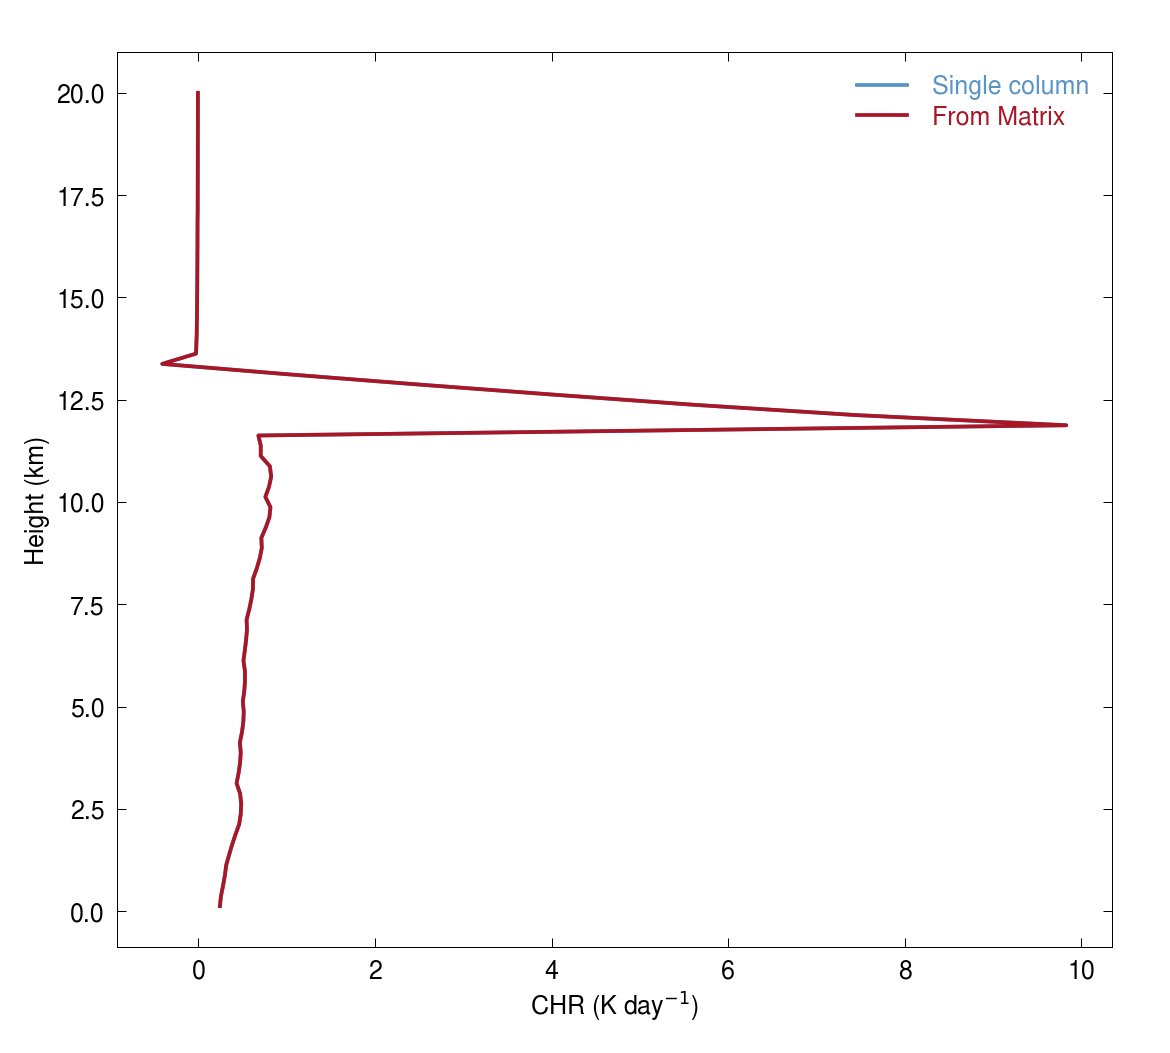

In [14]:
fontname = 'Nimbus Sans' # Arial
fontsize = 20
length   = 13 # inches
heigth   = length*.9 # inches

my_colors = [(88/255, 148/255, 197/255), (169/255, 23/255, 38/255),
             (229/255, 179/255, 69/255), (131/255, 170/255, 69/255),
             (116/255, 24/255, 123/255), (202/255, 91/255, 46/255),
             (107/255, 188/255, 233/255), 'grey']

f, ax = plt.subplots(figsize=(length,heigth), dpi=72)
plt.subplots_adjust(top = 0.95, bottom = 0.1, left = 0.1, right = 0.95)

h1 = ax.plot(H_lw, height_hl[0][:-1],
             linestyle = 'solid', 
             linewidth = 3, color = my_colors[0], alpha = 1)
h2 = ax.plot(H_lw_m[12,:], height_hl[0][:-1],
             linestyle = 'solid', 
             linewidth = 3, color = my_colors[1], alpha = 1)


# AXIS PARAMETERS
#X Axis
ax.set_xlabel(r'CHR (K day$^{-1}$)', fontname = fontname, 
              fontsize = fontsize, color = 'black', labelpad = 5)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
                    size = 7, direction = 'in', top = True,
                    labelsize = fontsize, pad=10)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)
    
#Y Axis
ax.set_ylabel('Height (km)', fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 5)

ax.tick_params(axis = 'y', which = 'major', color = 'black',
       size = 7, direction = 'in', right = True,
       labelsize = fontsize, pad = 10)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)

# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
handles = h1 + h2
labels  = ['Single column', 'From Matrix']
legend  = plt.legend(handles, labels, loc = 'upper right',
                     #bbox_to_anchor = (.5, .01),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 2, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_crh_re_1S_v4.png', dpi=500)

In [15]:
H_lw - H_lw_m[12,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])